## Generative Adversarial Network

Generative Adversarial Networks a.k.a GANs are emerging techniques that model high dimensional distribution of data. They achieve this by training a pair of networks, Generator and Discriminator, in competition with each other. As an analogy we can think of these models as an art forger and the other being an art expert. In GAN literature we term Generator as the forger and the duty of the generator is to produce fake images(forgeries) to deceive the art expert(Discriminator). The Discriminator which receives both the real images and fake images tries to distinguish between them and find the fake images. Both are trained simulataneously and are always in competition with each other. This competition between the Generator and Discriminator drives them to improve their models continuously. The models are trained until the generator produces the fake images that are indistinguishable with the real images.  <br>

In this setup, the generator do not have access to the synthetic images whereas the discriminator has access to both the real and fake images. While training the models, the supervisory signal to the discriminator is given by knowing whether the images came from a real image stack or generated image stack whereas the generator in the setup receives the error signal only from the discriminator.  

Let us define Discriminator D that takes image as input and produces a number **(0/1)** as output and a Generator G that takes random noise as input and outputs a fake image. In practise, G and D are trained alternately i.e., For a fixed generator G, the discriminator D is trained to classify the training data as real(output a value close to 1) or fake(output a value close to 0). In the next step we freeze the Discriminator assuming it as optimal and we the train the generator G to produce a image(fake) that outputs a value close to 1(real) when passed through the discriminator D. Thus, if the generator is perfectly trained then the discriminator D will be maximally confused by the images generated by G and predicts 0.5 for all the inputs. 



In this assignment, we will try to implement a Generative Adversarial Network on MNIST data and generate images that resemble the digits from the MNIST dataset.

To implement a GAN, we basically require 5 components:

- Real Dataset (real distribution)
- Low dimensional random noise that goes into the generator to produce fake images
- Generator that generates fake images
- Discriminator that acts as an expert to distinguish real and fake images.
- Training loop where the competition occurs and models better themselves


Let us implement each of the part and train the overall model:

In [141]:
## import packages

import torch
import random
import numpy as np
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'



## Checks for the availability of GPU 
if torch.cuda.is_available():
    print("working on gpu!")
    device = 'cuda'
else:
    print("No gpu! only cpu ;)")
    device = 'cpu'
    
## The following random seeds are just for deterministic behaviour of the code and evaluation

##############################################################################
################### DO NOT MODIFY THE CODE BELOW #############################    
##############################################################################

if device == 'cpu':    
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
elif device == 'cuda':
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = '42'

############################################################################### 

No gpu! only cpu ;)


In [142]:
def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

In [143]:
import torchvision
import torchvision.transforms as transforms
import os

if not os.path.isdir('./data'):
    os.mkdir('./data')
root = './data/'

train_bs = 64

training_data = torchvision.datasets.MNIST(root, train=True, transform=transforms.ToTensor(),download=True)
train_loader=torch.utils.data.DataLoader(dataset=training_data, batch_size=train_bs, shuffle=True, drop_last=True)


In GANs we input random noise through the generator to produce fake images which resemble the real distribution. Let us define a function which takes (batchsize, dimension) as input and returns a random noise of requested dimensions.

In [144]:
## bs - batchsize, dim - input dimension of random noise
## return a random noise of requested dimension from a normal distribution. 
def noise(bs, dim):
    out = torch.randn((bs, dim))
    return out
a = noise(8,15)
print(a.size())

torch.Size([8, 15])


Generator architecture:

- noise_dim -> 1024
- ReLU
- 1024 -> 1024
- ReLU
- 1024 -> 784
- TanH 
- clip image [-1, +1]

In [145]:
## In this cell we define a generator which takes in random noise as input and outputs a image of size equal
## to the images from real distribution

## we follow the same style for defining the model as worked in our previous assignments.
class Generator(nn.Module):
    def __init__(self, noise_dim=100, out_size=784):
        super(Generator, self).__init__()
        
        ### MODEL HERE ######
        ### define a fully connected layer from input_dim -> 1024
        self.layer1 = nn.Linear(noise_dim, 1024)
        self.relu = nn.ReLU()
        ### define a ReLU activation function
        
        ### define a fully connected layer from 1024 -> 1024
        self.layer2 = nn.Linear(1024, 1024)
        ### define a ReLU activation function
        self.tanh = nn.Tanh()
        ### define a fully connected layer from 1024 -> 1024
        self.layer3 = nn.Linear(1024, out_size)
        ### define a TanH activation function
        
    def forward(self, x):
        ### Make a forward pass of the model through the layers as described in the 
        ### generator architecture
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        x = self.tanh(x)
        x = torch.clamp(x, -1, 1)
        
        ### clip the individual values of the output vector such that all the values lie between [-1, +1]
        x = x.view(x.size(0), 1, 28, 28)
#         x = deprocess_img(x)
        return x
        
        
        
        

Discriminator architecture:

- input_size->256
- LeakyReLU alpha=0.01
- 256e->256
- LeakyReLU alpha-=0.01
- 256->1

In [146]:
## Similar to the generator, we now define a discriminator which takes in a vector and output a value between 
## 0 and 1. We define the Discriminator as given in the above architecture.

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        ## define a fully connected layer from from input_dim -> 256
        self.layer1 = nn.Linear(784, 256)
        
        ### define a LeakyReLU activation function with alpha 0.01
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        
        ### define a fully connected layer from 256 -> 256
        self.layer2 = nn.Linear(256, 256)
        
        ### define a LeakyReLU activation function with alpha 0.01
        
        ### define a fully connected layer from 256 -> 1
        self.layer3 = nn.Linear(256, 1)
        
    def forward(self, x):
        ### Make a forward pass of the model through the layers as described in the 
        ### Discriminator architecture
        x = x.view(x.size(0), -1)
        x = self.layer1(x)
        x = self.leaky_relu(x)
        x = self.layer2(x)
        x = self.leaky_relu(x)
        x = self.layer3(x)
        
        
        return x
        
        

In [147]:
bce_loss = nn.BCEWithLogitsLoss()

In [148]:
def DLoss(logits_real, logits_fake, targets_real, targets_fake):
    d1 = bce_loss(logits_real, targets_real)
    d2 = bce_loss(logits_fake.detach(), targets_fake)
    total_loss = d1 + d2
    avg_loss = torch.mean(total_loss)
    return avg_loss
    

In [149]:
def GLoss(logits_fake, targets_real):
    g_loss = bce_loss(logits_fake, targets_real)
    avg_loss = torch.mean(g_loss)
    return avg_loss

In [150]:
noise_dim = 100
epochs = 100

generator = Generator(noise_dim)
discriminator = Discriminator()

In [151]:
## Now, we define an optimization strategy to optimize the model weights. For this assignment we will use a
## stochastic gradient descent 

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))



















  0%|          | 0/100 [00:00<?, ?it/s]

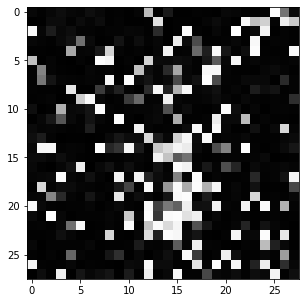



















  1%|          | 1/100 [00:27<44:54, 27.22s/it]

















  2%|▏         | 2/100 [00:53<44:10, 27.05s/it]

















  3%|▎         | 3/100 [01:20<43:36, 26.98s/it]

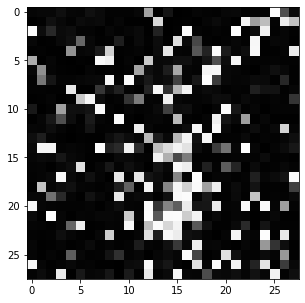



















  4%|▍         | 4/100 [01:53<46:03, 28.79s/it]

















  5%|▌         | 5/100 [02:21<45:03, 28.46s/it]

















  6%|▌         | 6/100 [02:47<43:33, 27.80s/it]

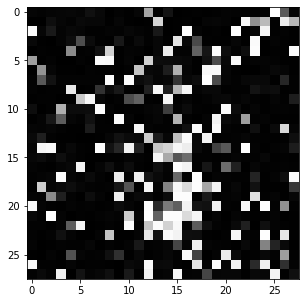



















  7%|▋         | 7/100 [03:14<42:41, 27.54s/it]

















  8%|▊         | 8/100 [03:41<41:54, 27.33s/it]

















  9%|▉         | 9/100 [04:07<40:58, 27.01s/it]

KeyboardInterrupt: 

In [152]:
## Training loop

from tqdm import tqdm, trange

for epoch in trange(epochs, leave=False):
    for i, (images, _) in enumerate(train_loader):
        targets_real = torch.ones((images.size(0), 1), requires_grad=False)
        targets_fake = torch.zeros((images.size(0), 1), requires_grad=False)
        
        optimizer_D.zero_grad()
        real_logits = discriminator(preprocess_img(images))
        fake_images = generator(noise(train_bs, noise_dim)).detach()
        fake_logits = discriminator(fake_images)
        
        discriminator_loss = DLoss(real_logits, fake_logits, targets_real, targets_fake)
        discriminator_loss.backward()
        optimizer_D.step()
        
        optimizer_G.zero_grad()
        
        fake_images = generator(noise(train_bs, noise_dim))
        fake_logits = discriminator(fake_images)
        
        generator_loss = GLoss(fake_logits, targets_real)
        generator_loss.backward()
        optimizer_G.step()
    
    if epoch % 3 == 0:
        viz_batch = fake_images.data.cpu().numpy()
        fig = plt.figure(figsize=(5,5))
        img = viz_batch[1].squeeze()
        plt.imshow(img)
        plt.show()
